#import

In [1]:
!pip install torch --upgrade
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (0.4.0)


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons
import copy

#init

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
class Basic_Net(nn.Module):
    def __init__(self,size_layers=20):
        super(Basic_Net,self).__init__()
        self.linear1 = nn.Linear(2, size_layers)
        self.linear2 = nn.Linear(size_layers, size_layers)
        self.linear3 = nn.Linear(size_layers, 2)

    def forward(self,x):
        x = F.dropout(F.relu(self.linear1(x)),0.4)
        x = F.dropout(F.relu(self.linear2(x)),0.4)
        x = self.linear3(x)
        return x

In [0]:
import contextlib
@contextlib.contextmanager

def _disable_tracking_bn_stats(model):

    def switch_attr(m):
        if hasattr(m, 'track_running_stats'):
            m.track_running_stats ^= True
            
    model.apply(switch_attr)
    yield
    model.apply(switch_attr)


def _l2_normalize(d):
    d_reshaped = d.view(d.shape[0], -1, *(1 for _ in range(d.dim() - 2)))
    d /= torch.norm(d_reshaped, dim=1, keepdim=True) + 1e-8
    return d


def _kl_div(log_probs, probs):
    # pytorch KLDLoss is averaged over all dim if size_average=True
    kld = F.kl_div(log_probs, probs, size_average=False)
    return kld / log_probs.shape[0]


class VATLoss(nn.Module):

    def __init__(self, xi=10.0, eps=1.0, ip=1):
        """VAT loss
        :param xi: hyperparameter of VAT (default: 10.0)
        :param eps: hyperparameter of VAT (default: 1.0)
        :param ip: iteration times of computing adv noise (default: 1)
        """
        super(VATLoss, self).__init__()
        self.xi = xi
        self.eps = eps
        self.ip = ip

    def forward(self, model, x):
        with torch.no_grad():
            pred = F.softmax(model(x), dim=1)

        # prepare random unit tensor
        d = torch.rand(x.shape).to(device)
        d = _l2_normalize(d)

        with _disable_tracking_bn_stats(model):
            # calc adversarial direction
            for _ in range(self.ip):
                d.requires_grad_()
                pred_hat = model(x + self.xi * d)
                adv_distance = _kl_div(F.log_softmax(pred_hat, dim=1), pred)
                adv_distance.backward()
                d = _l2_normalize(d.grad)
                model.zero_grad()
    
            # calc LDS
            r_adv = d * self.eps
            pred_hat = model(x + r_adv)
            lds = _kl_div(F.log_softmax(pred_hat, dim=1), pred)

        return lds


#code

acc base : 0.88125
acc VAT : 0.78


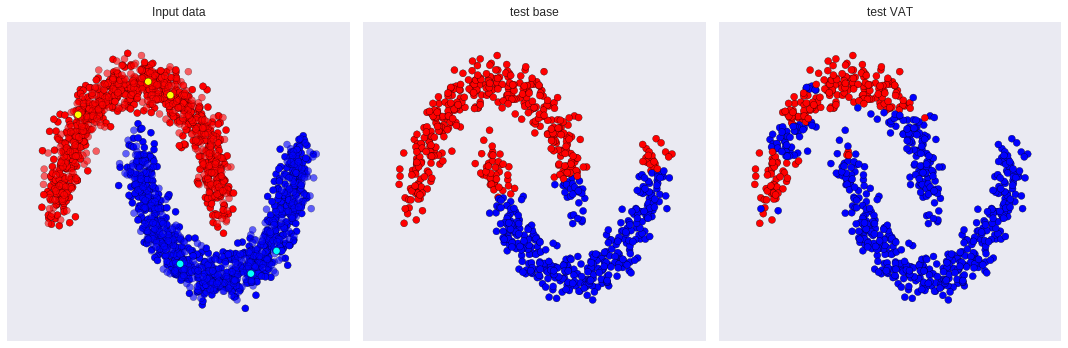

In [36]:
#param

samples_size = 1000 #unlabeled
vat_ratio = 0.6

nb_epoch = 1000

layers_size = 20

random_labels = False 

## or preset
# t_X_6 = np.array([[0.13,1.3],[0.5,-0.1],[-1.6,0.3],[-0.43,-0.55],[0.01,-1],[1.4,-0.7]])
# t_X_6 = np.array([[0.13,1.3],[-0.2,1.51],[-1.6,0.3],[1.03,-0.95],[0.01,-1],[1.4,-0.7]])
t_X_6 = np.array([[-0.13,1.3],[-0.45,1.51],[-1.46,1.0],[1.03,-1.45],[0.01,-1.3],[1.4,-1.1]])
t_y_6 = np.array([0,0,0,1,1,1])

#############################################################

h = .02  # step size in the mesh

if random_labels:
    samples_size += 6

# dataset = make_moons(n_samples = samples_size, noise=0.05, random_state=0)  # no random same seed
dataset = make_moons(n_samples = samples_size, noise=0.1, random_state=None)

figure = plt.figure(figsize=(15, 5))
i = 1

# preprocess dataset, split into training and test part
X, y = dataset
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

if random_labels:
    t_X_6 = X_train[:6]
    X_train = X_train[6:]
    t_y_6 = y_train[:6]
    y_train = y_train[6:]
    

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# just plot the dataset first
cm = plt.cm.RdBu

ax = plt.subplot(1, 3, i)
i += 1

ax.set_title("Input data")



# Plot the points
cm_bright = ListedColormap(['#FF0000', '#0000FF']) # rouge / bleu
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
# and testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k')


cm_bright_t = ListedColormap(['#FFFF00', '#00FFFF']) # jaune / cyan
ax.scatter(t_X_6[:, 0], t_X_6[:, 1], c=t_y_6, cmap=cm_bright_t, edgecolors='k')


ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

#########################################################################################################

t_X = torch.Tensor(X_train).to(device)
t_y = torch.LongTensor(y_train).to(device)

t_X_6 = torch.Tensor(t_X_6).to(device)
t_y_6 = torch.LongTensor(t_y_6).to(device)


net_base = Basic_Net(layers_size).to(device)

net_vat = copy.deepcopy(net_base)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_base.parameters())


net_base.train()
for _ in range(nb_epoch):
    optimizer.zero_grad()

    res = net_base(t_X_6)
    loss = criterion(res,t_y_6)
    loss.backward()
    optimizer.step()

net_base.eval()

test_X = torch.Tensor(X_test).to(device)
test_y = torch.LongTensor(y_test).to(device)

res = net_base(test_X)


acc = 1 - ((res.max(dim = 1)[1] + test_y) % 2).sum().item() / res.shape[0]
print(f"acc base : {acc}")

ax = plt.subplot(1, 3, i)
i += 1

ax.set_title("test base")

tyt = res.max(dim = 1)[1]
ax.scatter(X_test[:, 0], X_test[:, 1], c=tyt, cmap=cm_bright, edgecolors='k')


ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

#################################

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_vat.parameters())


net_vat.train()
for _ in range(nb_epoch):
    optimizer.zero_grad()

    #
    vat_t = t_X
    vat_t = vat_t.detach()
    vat_loss = VATLoss(xi=0.1)
    loss_vat = vat_loss(net_vat, vat_t)
    #

    res = net_vat(t_X_6)
    loss = criterion(res,t_y_6) + loss_vat * vat_ratio
    loss.backward()
    optimizer.step()

net_vat.eval()

test_X = torch.Tensor(X_test).to(device)
test_y = torch.LongTensor(y_test).to(device)

res = net_vat(test_X)


acc = 1 - ((res.max(dim = 1)[1] + test_y) % 2).sum().item() / res.shape[0]
print(f"acc VAT : {acc}")


ax = plt.subplot(1, 3, i)
i += 1

ax.set_title("test VAT")

tyt = res.max(dim = 1)[1]
ax.scatter(X_test[:, 0], X_test[:, 1], c=tyt, cmap=cm_bright, edgecolors='k')


ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())


###?
plt.tight_layout()
plt.show()